---
title: 6.5 批量规范化
date: 2024-4-22 14:00:00
tags: [机器学习,pytorch]
categories: [机器学习]
comment: true
toc: true
---
#
<!--more-->
# 5 批量规范化
- 训练深层神经网络十分困难。批量规范化（batchnormalization）可持续加速深层网络的收敛速度。
## 5.1 训练深层网络
- 训练神经网络时出现的一些挑战：
    - 数据预处理的方式通常会对最终结果产生巨大影响。例如使用真实数据时，我们的第一步是标准化输入特征，使其平均值为0，方差为1。直观地说，这种标准化可以很好地与我们的优化器配合使用，因为它可以将参数的量级进行统一。
    - 中间层中的变量（例如，多层感知机中的仿射变换输出）可能具有更广的变化范围
    - 更深层的网络很复杂，容易过拟合。这意味着正则化变得更加重要。
- 批量规范化应用于单个可选层（也可以应用到所有层），其原理如下：在每次训练迭代中，我们首先规范化输入，即通过减去其均值并除以其标准差，其中两者均基于当前小批量处理。接下来，我们应用比例系数和比例偏移。正是由于这个基于批量统计的标准化，才有了批量规范化的名称。
- 如果使用大小为1的小批量应用批量规范化，我们将无法学到任何东西。这是因为在减去均值之后，每个隐藏单元将为0。所以，只有使用足够大的小批量，批量规范化这种方法才是有效且稳定的。请注意，在应用批量规范化时，批量大小的选择可能比没有批量规范化时更重要。
- 用$\mathbf{x} \in \mathcal{B}$表示一个来自小批量$\mathcal{B}$的输入，批量规范化定义为

$$\mathrm{BN} ( \mathbf{x})= \boldsymbol{ \gamma} \odot \frac{ \mathbf{x}- \hat{ \boldsymbol{ \mu}}_ \mathcal{B}}{ \hat{ \boldsymbol{ \sigma}}_ \mathcal{B}} + \boldsymbol{ \beta}$$

$$\begin{aligned}
&\hat{\boldsymbol{\mu}}_ {\mathcal{B}} = \frac1{| \mathcal{B}|} \sum_{ \mathbf{x} \in \mathcal{B}} \mathbf{x}, \\ 
&\hat{\boldsymbol{ \sigma}}_ { \mathcal{B}}^ 2 = \frac1{| \mathcal{B}|} \sum_ { \mathbf{x} \in \mathcal{B}}( \mathbf{x} - \hat{ \boldsymbol{ \mu}}_ \mathcal{B})^ 2+ \epsilon. 
\end{aligned}$$
- $\gamma$和$\beta$是可以学习的参数向量, $\epsilon$防止除0
- 在训练过程中，我们无法得知使用整个数据集来估计平均值和方差，所以只能根据每个小批次的平均值和方差不断训练模型。而在预测模式下，可以根据整个数据集精确计算批量规范化所需的平均值和方差。

## 5.2 批量规范化层
- 讨论两种情况：全连接层和卷积层，他们的批量规范化实现略有不同。
### 5.2.1 全连接层
- 通常，我们将批量规范化层置于全连接层中的仿射变换和激活函数之间。设全连接层的输入为x，权重参数为$\mathbf{W}$，偏差参数为$ \mathbf{b}$，激活函数为$\phi$。设批量规范化的运算符为$\mathrm{BN}$。那么，使用批量规范化的全连接层的输出的计算表达式为：
$$\mathbf{h}= \phi( \mathrm{BN}( \mathbf{W} \mathbf{x} + \mathbf{b}))$$
### 5.2.2 卷积层
- 对于卷积层，我们可以在卷积层之后和非线性激活函数之前应用批量规范化。对每个通道的输出执行批量规范化，每个通道都有自己的拉伸（scale）和偏移（shift）参数，这两个参数都是标量。
- 假设我们的小批量包含m个样本，并且对于每个通道，卷积的输出具有高度p和宽度q。那么对于卷积层，我们在每个输出通道的m · p · q个元素上同时执行每个批量规范化。
### 5.2.3 预测过程中的批量规范化
- 批量规范化在训练模式和预测模式下的行为通常不同。
- 预测时，我们不再需要样本均值中的噪声以及在微批次上估计每个小批次产生的样本方差了。
- 其次，例如，我们可能需要使用我们的模型对逐个样本进行预测。一种常用的方法是通过移动平均估算整个训练数据集的样本均值和方差，并在预测时使用它们得到确定的输出。可见，和暂退法一样，批量规范化层在训练模式和预测模式下的计算结果也是不一样的。

## 5.3 从零实现
- 基础设计模式：
    - 用一个单独的函数定义其数学原理
    - 然后将次功能集成到一个自定义层中，其代码主要处理数据移动到训练设备，初始化变量、跟踪移动平均线。

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 通过is_grad_enabled来判断当前模型是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat= (X-moving_mean) / torch.sqrt(moving_var +eps)
    else:
        assert len(X.shape) in (2,4)
        if len(X.shape) == 2:
            mean = X.mean(dim=0)
            var = ((X-mean)**2).mean(dim=0)
        else:
            # 使用二维卷积层的情况，计算通道维度上（axis = 1)的均值和方差
            # 这里我们需要保持X的形状以便后面可以做广播运算
            mean = X.mean(dim=(0,2,3), keepdim = True)
            var = ((X - mean)**2).mean(dim=(0,2,3), keepdim=True)
        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X-mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta #缩放和位移
    return Y, moving_mean, moving_var


- 创建BatchNorm层。
- 参数：gamma,beta，这两个参数将在训练过程中更新。此外，我们的层将保存均值和方差的平均移动值，以便在模型预测期间随后使用。

In [2]:
class BatchNorm(nn.Module):
    # num_features: 完全连接层的输出数量或卷积层的输出通道数
    # num_dim: 2表示完全连接，4表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1,1)
        # 参与求梯度和迭代的拉伸和偏移参数， 分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)
    def forward(self, X):
        # 如果X不在内存上， 将moving_mean和moving_var复制到X所在显卡上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean, self.moving_var, eps=1e-5, momentum=0.9
        )
        return Y

## 5.4 使用批量规范化层的LeNet
- 将BatchNorm应用于LeNet模型

loss 0.267, train acc 0.900, test acc 0.812
4058.4 examples/sec on cpu


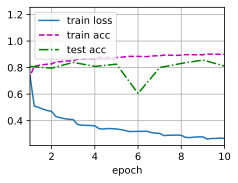

In [3]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10)
)

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" 
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 5.5 简明实现
- 通常高级API变体运行速度快得多，因为它的代码已编译为C++或CUDA，而我们的自定义代码由Python实现。

loss 0.271, train acc 0.899, test acc 0.845
7140.4 examples/sec on cpu


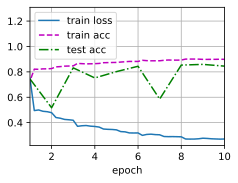

In [4]:
net = nn.Sequential(
    nn.Conv2d(1,6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10)
)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 5.6 争议
- 批量规范化被认为可以使优化更加平滑。我们甚至不知道简单的神经网络（多层感知机和传统的卷积神经网络）为什么如此有效。即使在暂退法和权重衰减的情况下，它们仍然非常灵活，因此无法通过常规的学习理论泛化保证来解释它们是否能够泛化到看不见的数据。
- 其原理：通过减少内部协变量偏移（internal covariate shift）。据推测，作者所说的内部协变量转移类似于上述的投机直觉，即变量值的分布在训练过程中会发生变化。然而，这种解释有两个问题：1、这种偏移与严格定义的协变量偏移（covariate shift）非常不同，所以这个名字用词不当；2、这种解释只提供了一种不明确的直觉，但留下了一个有待后续挖掘的问题：为什么这项技术如此有效？
